<h1 style="display: inline;" >3. Generalized Linear Model

# 3.1 Theory

The generalized linear model (GLM) is a generalization of linear regression. In linear regression, a dependent variable, $y$, is modeled as the linear combination of a number of regressors, $\mathbf{x}$:

<p><div align=center>$y = \mathbf{w}^T\mathbf{x} + b + \epsilon$</div></p>

where it is assumed that the error term, $\epsilon$, is normally distributed.

The GLM is an extension of this in two ways. First, the error term can be other than Gaussian. This gives us the <em>family</em> of the GLM model, e.g. binomial, poisson, gamma. Second, the expected value, $E(y)$ can be made non-linear by means of a <em>link function</em>:

<p><div align=center>$g(y) = \mathbf{w}^T\mathbf{x} + b + \epsilon$</div></p>

For example, for non-negative data the log function may be used:

<p><div align=center>$\log y = \mathbf{w}^T\mathbf{x} + b + \epsilon$</div></p>

For $y$ ranging from zero to one, the logit function may be used, $\log \frac{x}{1-x}$, giving rise to <em>logistical regression.</em> Logistical regression is often used in classification problems where $y \in \{0,1\}$.

Here we look at the GLM implementation in H2O, using it to predict flight delays on the basis of airline and weather data.

# 3.1 Data Munging

In [1]:
import h2o
h2o.init(strict_version_check = False)

[WARNING] H2O requires requests module of version 2.10 or newer. You have version 2.6.0.
You can upgrade to the newest version of the module running from the command line
    $ pip2 install --upgrade requests
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,45 mins 39 secs
H2O cluster version:,3.14.0.6
H2O cluster version age:,10 days
H2O cluster name:,ec2-user
H2O cluster total nodes:,2
H2O cluster free memory:,921 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [5]:
flights = h2o.import_file("hdfs://ec2-34-204-73-232.compute-1.amazonaws.com:9000/allyears2k.csv")
weather = h2o.import_file("hdfs://ec2-34-204-73-232.compute-1.amazonaws.com:9000/Chicago_Ohare_International_Airport.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
flights.head(5)

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,IsArrDelayed,IsDepDelayed
1987,10,14,3,741,730,912,849,PS,1451,NA,91,79,nan,23,11,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,YES
1987,10,15,4,729,730,903,849,PS,1451,NA,94,79,nan,14,-1,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,NO
1987,10,17,6,741,730,918,849,PS,1451,NA,97,79,nan,29,11,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,YES
1987,10,18,7,729,730,847,849,PS,1451,NA,78,79,nan,-2,-1,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,NO,NO
1987,10,19,1,749,730,922,849,PS,1451,NA,93,79,nan,33,19,SAN,SFO,447,nan,nan,0,NA,0,nan,nan,nan,nan,nan,YES,YES


**We convert the 'IsDelayed' columns from strings to binary:**

In [7]:
for col in ['IsArrDelayed','IsDepDelayed']:
   flights[col] = flights[col].sub("NO","0")
   flights[col] = flights[col].sub("YES","1")
   flights[col] = flights[col].asnumeric()

** Changing the date formats:**

In [8]:
weather.head(5)

Date,TmaxF,TminF,TmeanF,PrcpIn,SnowIn,CDD,HDD,GDD
2005-01-01 00:00:00,41,25,33,0.31,0,0,32,0
2005-01-02 00:00:00,54,33,43.5,0.08,0,0,21.5,0
2005-01-03 00:00:00,36,32,34,0.36,0,0,31,0
2005-01-04 00:00:00,35,30,32.5,0.05,1.2,0,32.5,0
2005-01-05 00:00:00,31,26,28.5,0.38,6.2,0,36.5,0


In [9]:
from datetime import datetime

weather['Year'] = weather['Date'].year()
weather['Month'] = weather['Date'].month()
weather['DayofMonth'] = weather['Date'].day()
print "Weather data ranges from " + str(int(weather['Year'].min())) + " to " + str(int(weather['Year'].max()))
print "Flight data ranges from " + str(int(flights['Year'].min())) + " to " + str(int(flights['Year'].max()))

Weather data ranges from 2005 to 2008
Flight data ranges from 1987 to 2008


** Filtering flights to those in/out of O'Hare: **

In [10]:
chi_flights = flights[(flights['Origin'] == 'ORD') | (flights['Dest'] == 'ORD')]
chi_flights['Arriving'] = (chi_flights['Dest'] == 'ORD')
print "Number of flights departing ORD: " + str(chi_flights[chi_flights['Arriving'] == 0].shape[0])
print "Number of flights arriving at ORD: " + str(chi_flights[chi_flights['Arriving'] == 1].shape[0])
print "Total ORD flights: " + str(chi_flights.shape[0])

Number of flights departing ORD: 2246
Number of flights arriving at ORD: 2103
Total ORD flights: 4349


** Merging the two datasets. ** Here we perform an innter join. (We could also perform a left outer join if we wanted to also train on flights for which there is no weather information).

In [11]:
chicago = chi_flights.merge(weather, by_x=['Year','Month','DayofMonth'], by_y=['Year','Month','DayofMonth'])
print chi_flights.shape

(4349, 32)


# 3.2 Data Exploration

To develop a regression model requires some insight into the data. While some data exploration is possible in H2O, it is not primarily designed for this. Here we load the data into Python for some visualization:

In [12]:
chicago_df = chicago.as_data_frame()

Looking at missing values:

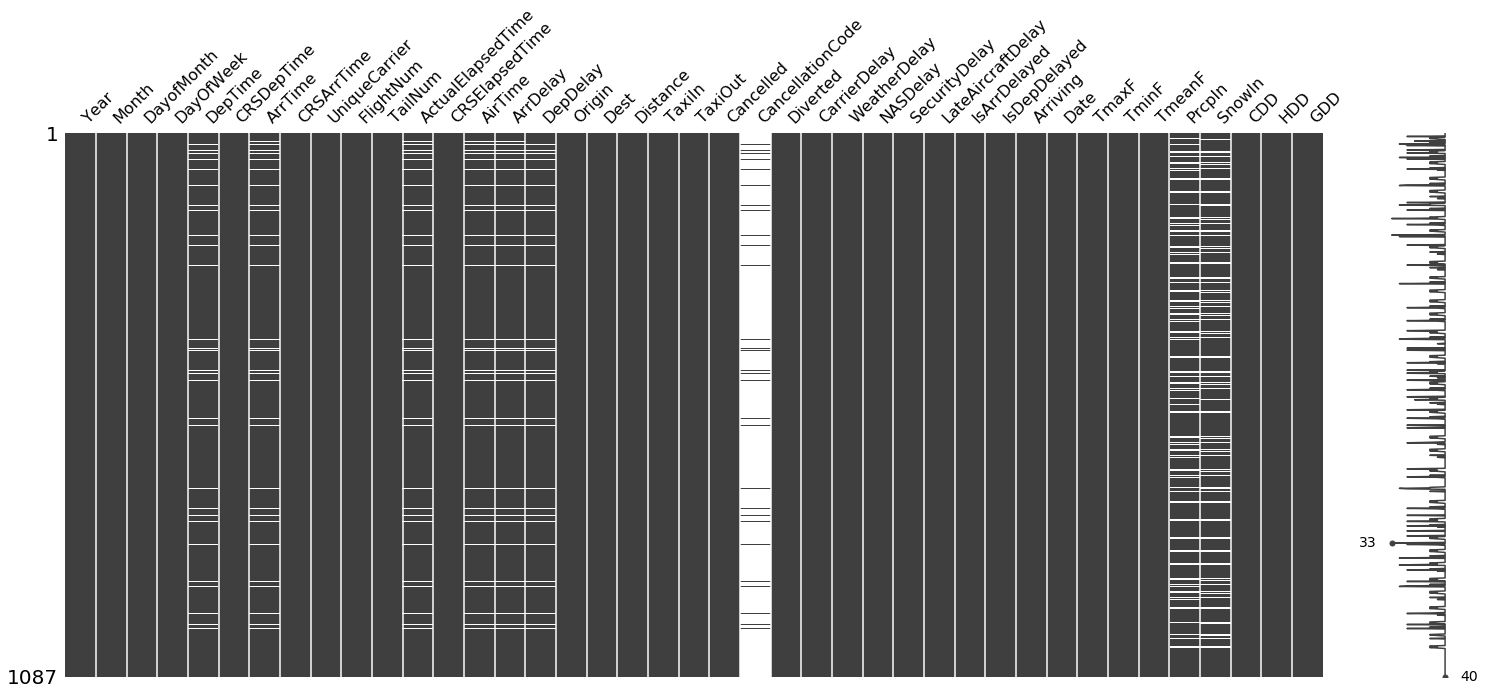

In [14]:
%matplotlib inline
import missingno as msno
msno.matrix(chicago_df)

<br>
<br>
Next, we will make a predictive model about flight depature delays. Our regressands will be DepDelay (continuous) and IsDepDelayed (binary). We will not include any of the various 'delay' columns (they give away too much; they come after the fact, and aren't predictive).

Let's make sure our two chosen Delay variables are consistent. We see that DepDelay can be negative, but is only so when IsDepDelayed=0:

/usr/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/lib64/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


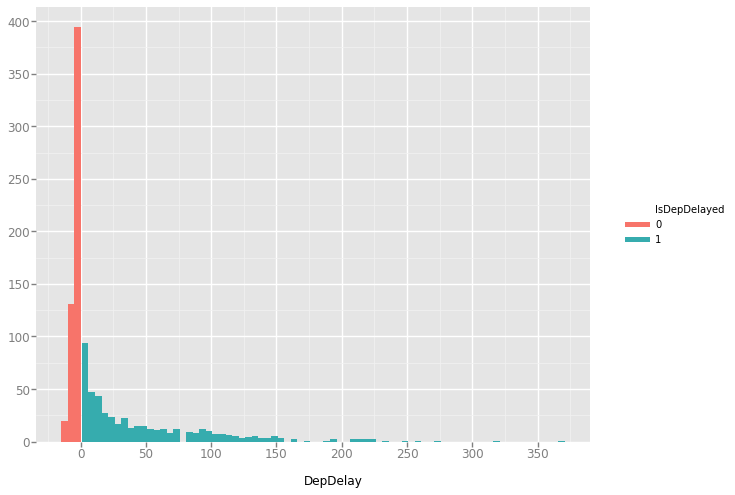

<ggplot: (7007353)>

In [15]:
from ggplot import *
chicago_df['IsDepDelayed'] = chicago_df['IsDepDelayed'].astype(object)
ggplot(aes(x='DepDelay', fill='IsDepDelayed'), data=chicago_df) + geom_histogram(binwidth=5)

The mean delay, given a flight delay:

In [16]:
chicago_df[chicago_df['IsDepDelayed'] == 1]['DepDelay'].mean()

47.981288981288984

Let's look at some categorical variables that we might consider including:

In [17]:
chicago_df[['UniqueCarrier','Origin','Dest','FlightNum']].nunique()

UniqueCarrier     2
Origin           23
Dest             24
FlightNum        86
dtype: int64

In [18]:
chicago_df.groupby('UniqueCarrier').describe()

ActualElapsedTime                                              \
                          count        mean        std   min     25%    50%   
UniqueCarrier                                                                 
UA                        968.0  149.500000  61.579083  51.0  102.00  137.0   
US                         56.0  151.160714  47.262431  74.0  114.25  139.0   

                            AirTime               ...   WeatherDelay        \
                 75%    max   count        mean   ...            75%   max   
UniqueCarrier                                     ...                        
UA             190.0  364.0   968.0  122.340909   ...            0.0  59.0   
US             207.0  227.0    56.0  120.625000   ...            0.0  22.0   

                 Year                                                       
                count    mean  std     min     25%     50%     75%     max  
UniqueCarrier                                                               
UA             1031.0  2005.0  0.0  2005.0  2005.0  2005.0  2005.0  2005.0  
US               56.0  2006.0  0.0  2006.0  2006.0  2006.0  2006.0  2006.0  

[2 rows x 280 columns]

# 3.3 GLM Classification Models

First we will build a model for whether a flight departure is delayed. Let's start with just the weather information:

In [19]:
x_cols = ['TmaxF','TminF','TmeanF','PrcpIn','SnowIn','CDD','HDD','GDD']
y_col = 'IsDepDelayed'

In [20]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

model = H2OGeneralizedLinearEstimator(family='binomial', response_column=y_col, nfolds=5)
model.train(x=x_cols, y=y_col, training_frame=chicago[chicago['Origin']=='ORD'])
model.show()

glm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1508442729868_7


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.223873948673
RMSE: 0.473153197889
LogLoss: 0.639743666982
Null degrees of freedom: 525
Residual degrees of freedom: 521
Null deviance: 717.581526075
Residual deviance: 673.010337665
AIC: 683.010337665
AUC: 0.670914143803
Gini: 0.341828287606
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.424314079528: 


,0,1,Error,Rate
0,47.0,177.0,0.7902,(177.0/224.0)
1,17.0,285.0,0.0563,(17.0/302.0)
Total,64.0,462.0,0.3688,(194.0/526.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4243141,0.7460733,26.0
max f2,0.3093922,0.8708189,30.0
max f0point5,0.5230997,0.7006803,16.0
max accuracy,0.4677130,0.6577947,21.0
max precision,0.8508695,0.8125,0.0
max recall,0.3093922,1.0,30.0
max specificity,0.8508695,0.9866071,0.0
max absolute_mcc,0.5230997,0.2967031,16.0
max min_per_class_accuracy,0.5838085,0.6428571,15.0
max mean_per_class_accuracy,0.5838085,0.6492431,15.0


Gains/Lift Table: Avg response rate: 57.41 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0,0.8508695,0.0,nan,0.0,nan,0.0,0.0,-100.0,nan
,2,0.0304183,0.8366806,1.4151490,1.4151490,0.8125,0.8125,0.0430464,0.0430464,41.5149007,41.5149007
,3,0.0722433,0.8319509,1.1875376,1.2833740,0.6818182,0.7368421,0.0496689,0.0927152,18.7537628,28.3373998
,4,0.1387833,0.7836194,1.4929044,1.3838338,0.8571429,0.7945205,0.0993377,0.1920530,49.2904447,38.3833802
,5,0.1692015,0.7375369,1.0885762,1.3307538,0.625,0.7640449,0.0331126,0.2251656,8.8576159,33.0753776
,6,0.2224335,0.6855630,0.9330653,1.2355805,0.5357143,0.7094017,0.0496689,0.2748344,-6.6934721,23.5580461
,7,0.3193916,0.6463640,1.1952993,1.2233523,0.6862745,0.7023810,0.1158940,0.3907285,19.5299312,22.3352255
,8,0.4201521,0.6168732,1.1830564,1.2136885,0.6792453,0.6968326,0.1192053,0.5099338,18.3056354,21.3688532
,9,0.5285171,0.5838085,1.3444870,1.2405069,0.7719298,0.7122302,0.1456954,0.6556291,34.4487045,24.0506932
,10,0.6121673,0.4964643,0.7916918,1.1791781,0.4545455,0.6770186,0.0662252,0.7218543,-20.8308248,17.9178150




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.227220937408
RMSE: 0.47667697386
LogLoss: 0.648039842908
Null degrees of freedom: 525
Residual degrees of freedom: 519
Null deviance: 719.272224828
Residual deviance: 681.737914739
AIC: 695.737914739
AUC: 0.654971322138
Gini: 0.309942644276
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.412769202139: 


,0,1,Error,Rate
0,33.0,191.0,0.8527,(191.0/224.0)
1,13.0,289.0,0.043,(13.0/302.0)
Total,46.0,480.0,0.3878,(204.0/526.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4127692,0.7391304,133.0
max f2,0.2934221,0.8708189,147.0
max f0point5,0.5437506,0.7016925,78.0
max accuracy,0.5437506,0.6520913,78.0
max precision,0.7909441,0.7826087,12.0
max recall,0.2934221,1.0,147.0
max specificity,0.8751734,0.9955357,0.0
max absolute_mcc,0.5437506,0.2990147,78.0
max min_per_class_accuracy,0.5620449,0.6428571,77.0
max mean_per_class_accuracy,0.5437506,0.6508988,78.0


Gains/Lift Table: Avg response rate: 57.41 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0152091,0.8656631,1.3062914,1.3062914,0.75,0.75,0.0198675,0.0198675,30.6291391,30.6291391
,2,0.0247148,0.8631040,1.0450331,1.2058074,0.6,0.6923077,0.0099338,0.0298013,4.5033113,20.5807438
,3,0.0361217,0.8579283,0.5805740,1.0083653,0.3333333,0.5789474,0.0066225,0.0364238,-41.9426049,0.8365284
,4,0.0437262,0.8545684,1.3062914,1.0601785,0.75,0.6086957,0.0099338,0.0463576,30.6291391,6.0178520
,5,0.0532319,0.8280893,1.7417219,1.1818827,1.0,0.6785714,0.0165563,0.0629139,74.1721854,18.1882687
,6,0.1007605,0.7891443,1.4630464,1.3145071,0.84,0.7547170,0.0695364,0.1324503,46.3046358,31.4507060
,7,0.1539924,0.7567009,1.3062914,1.3116671,0.75,0.7530864,0.0695364,0.2019868,30.6291391,31.1667075
,8,0.2072243,0.6828539,1.1196783,1.2623489,0.6428571,0.7247706,0.0596026,0.2615894,11.9678335,26.2348867
,9,0.3003802,0.6436664,1.1729964,1.2346383,0.6734694,0.7088608,0.1092715,0.3708609,17.2996351,23.4638276
,10,0.4011407,0.6191254,1.1501937,1.2134271,0.6603774,0.6966825,0.1158940,0.4867550,15.0193677,21.3427074



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.6438627,0.0222186,0.6504855,0.5982906,0.6363636,0.6380953,0.6960784
auc,0.6626256,0.0296317,0.6853175,0.6465164,0.6403292,0.6097149,0.73125
err,0.3561373,0.0222186,0.3495146,0.4017094,0.3636364,0.3619048,0.3039216
err_count,37.6,3.7040517,36.0,47.0,36.0,38.0,31.0
f0point5,0.6713303,0.0248948,0.6884876,0.6182213,0.6521739,0.6744186,0.7233502
---,---,---,---,---,---,---,---
r2,0.0670512,0.0283915,0.0970578,0.0413247,0.0608097,0.0112092,0.1248545
recall,0.9515037,0.0205287,0.9682540,0.9344263,1.0,0.9354839,0.9193549
residual_deviance,136.34758,8.940779,126.92403,158.07344,130.58273,142.66937,123.48834
rmse,0.4761007,0.0095935,0.4631194,0.4891126,0.4825527,0.4889821,0.4567366



See the whole table with table.as_data_frame()
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2017-10-19 20:40:06,0.000 sec,0,358.7907630,0.6821117
,2017-10-19 20:40:06,0.019 sec,1,336.7539795,0.6404099
,2017-10-19 20:40:06,0.021 sec,2,336.5057378,0.6399538
,2017-10-19 20:40:06,0.024 sec,3,336.5051688,0.6399532


Now is a good time to discuss <em>validation</em>. It is generally customary to train a model on a subset of the data, withholding another subset for testing the trained model. A slightly more sophisticated technique is k-fold cross-validation, which repeats this process k times:

<img src=https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg>

When we specify nfolds=5, we thus perform 5-fold cross-validation, training the data on 80% of the data and validating the trained model on the other 20% (five times). This allows us to simultaneously train and test against all the data (while still avoiding overfitting). The only downside is training/testing time (which will be k-times as long).

Next let's look at some of the ways that a model can be measured/validated. Each of these are measure of error, or conversely, goodness of fit.

**Error:** The error of any given prediction is the difference between predicted and given values, ($y - \hat{y}$). We can then average the error — while the mean error isn't usually interesting (since it often averages to zero), the mean absolute error (MAE), mean-squared error (MSE), root-mean-squared error (RMSE) and root-mean-squared log-error (RMSLE) are all calculated by H2O (at least for regression problems).

**$r^2$:** $r^2$ is related to the mean-squared error. It can be thought of as the amount of the variance in $y$ that can be explained by $\mathbf{w}^T\mathbf{x} + b$:

$r^2 = 1 - \frac{\sum (y - \bar{y})^2}{\sum (\hat{y} - \bar{y})^2}$

**Logloss:** For classification models, log-loss is the most common validation metric. Sticking to binary classification, logistic regression can be seen as calculating a probability, $p$, of an input belonging to class 0 or 1. If it is determined that the input actually did belong to class 1, then the "error" (or logarithmic loss) is determined to be $-\log p$. If the input belongs to class 1, then the log-loss is $-\log(1-p)$

**Confusion matrix:** The confusion matrix of a classification model self-explanatory. It shows us how often classes are correctly identified, and how often they are confused for other classes. From this one can determine various measures, such as the false positive rate, accuracy, true positive rate, F1, F2, etc.

It should be pointed out that a logistic regression model is not strictly a classification model. A logistic regression model outputs $\hat{y} \in \{0,1\}$. We then require a threshold, $y_t$ above which we round $\hat{y}$ to one:

$
\hat{y} =\begin{cases}
    1,& \text{if } \mathbf{w}^T\mathbf{x} + b \geq y_t\\
    0,              & \text{otherwise}
\end{cases}$

While it is common to set $y_t = 0.5$, we need not. For example, false positives may be far more costly than false negatives, in which case we would set a higher $y_t$. This ability to vary the threshold gives us the receiver operating characteristic (ROC).

**ROC:** 

The ROC shows how the model performs as we vary the threshold from zero to one. The quality of the model can then be measured by the area under curve (AUC), ranging from zero to one. In practice, AUC should be between 0.5 and 1, as random guesses would average 0.5.

<img src=http://gim.unmc.edu/dxtests/roccomp.jpg>

Related to the AUC is the Gini coefficient. Gini = 2*AUC-1. Like the AUC it measures how steep the curve is (for this reason it commonly occurs in studies of income/wealth disparity).

Now that we've discussed these metrics, let's improve our logistic regression model. Let's add in some non-weather variables (most importantly, time):

In [21]:
x_cols = ['DepTime','Distance','TmaxF','TminF','TmeanF','PrcpIn','SnowIn','CDD','HDD','GDD']
chicago['FlightNum'] = chicago['FlightNum'].asfactor()
y_col = 'IsDepDelayed'
model = H2OGeneralizedLinearEstimator(family='binomial', response_column=y_col, nfolds=5, keep_cross_validation_predictions=True)
model.train(x=x_cols, y=y_col, training_frame=chicago[chicago['Origin']=='ORD'])
model.show()

glm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1508442729868_25


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.174876928795
RMSE: 0.41818288917
LogLoss: 0.524150010674
Null degrees of freedom: 525
Residual degrees of freedom: 519
Null deviance: 717.581526075
Residual deviance: 551.405811229
AIC: 565.405811229
AUC: 0.81015698912
Gini: 0.62031397824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.361049495916: 


,0,1,Error,Rate
0,121.0,103.0,0.4598,(103.0/224.0)
1,33.0,269.0,0.1093,(33.0/302.0)
Total,154.0,372.0,0.2586,(136.0/526.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3610495,0.7982196,281.0
max f2,0.2364994,0.8883553,340.0
max f0point5,0.7161205,0.7775769,143.0
max accuracy,0.4971609,0.7452471,241.0
max precision,0.9883556,1.0,0.0
max recall,0.0844153,1.0,397.0
max specificity,0.9883556,1.0,0.0
max absolute_mcc,0.4971609,0.4741286,241.0
max min_per_class_accuracy,0.5835265,0.7232143,206.0
max mean_per_class_accuracy,0.5332612,0.7333994,223.0


Gains/Lift Table: Avg response rate: 57.41 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0114068,0.9722916,1.7417219,1.7417219,1.0,1.0,0.0198675,0.0198675,74.1721854,74.1721854
,2,0.0209125,0.9636482,1.7417219,1.7417219,1.0,1.0,0.0165563,0.0364238,74.1721854,74.1721854
,3,0.0304183,0.9602464,1.3933775,1.6328642,0.8,0.9375,0.0132450,0.0496689,39.3377483,63.2864238
,4,0.0418251,0.9398791,1.7417219,1.6625527,1.0,0.9545455,0.0198675,0.0695364,74.1721854,66.2552679
,5,0.0513308,0.9273204,1.7417219,1.6772136,1.0,0.9629630,0.0165563,0.0860927,74.1721854,67.7213637
,6,0.1007605,0.9003488,1.5407539,1.6102711,0.8846154,0.9245283,0.0761589,0.1622517,54.0753948,61.0271148
,7,0.1501901,0.8733177,1.5407539,1.5873921,0.8846154,0.9113924,0.0761589,0.2384106,54.0753948,58.7392070
,8,0.2015209,0.8422504,1.6127054,1.5938398,0.9259259,0.9150943,0.0827815,0.3211921,61.2705421,59.3839810
,9,0.3003802,0.7794825,1.4402700,1.5432978,0.8269231,0.8860759,0.1423841,0.4635762,44.0269995,54.3297846
,10,0.4011407,0.7043522,1.2487817,1.4693199,0.7169811,0.8436019,0.1258278,0.5894040,24.8781707,46.9319858




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.18011120181
RMSE: 0.424395101067
LogLoss: 0.536884248061
Null degrees of freedom: 525
Residual degrees of freedom: 519
Null deviance: 719.637697698
Residual deviance: 564.80222896
AIC: 578.80222896
AUC: 0.798804103595
Gini: 0.59760820719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.310343212598: 


,0,1,Error,Rate
0,102.0,122.0,0.5446,(122.0/224.0)
1,23.0,279.0,0.0762,(23.0/302.0)
Total,125.0,401.0,0.2757,(145.0/526.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3103432,0.7937411,302.0
max f2,0.2148653,0.8851675,349.0
max f0point5,0.5574129,0.7666214,215.0
max accuracy,0.4259574,0.7376426,264.0
max precision,0.9911317,1.0,0.0
max recall,0.1139733,1.0,391.0
max specificity,0.9911317,1.0,0.0
max absolute_mcc,0.4227939,0.4569403,265.0
max min_per_class_accuracy,0.5892199,0.7142857,206.0
max mean_per_class_accuracy,0.5574129,0.7246186,215.0


Gains/Lift Table: Avg response rate: 57.41 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0114068,0.9757998,1.7417219,1.7417219,1.0,1.0,0.0198675,0.0198675,74.1721854,74.1721854
,2,0.0209125,0.9691814,1.3933775,1.5833835,0.8,0.9090909,0.0132450,0.0331126,39.3377483,58.3383504
,3,0.0304183,0.9584616,1.7417219,1.6328642,1.0,0.9375,0.0165563,0.0496689,74.1721854,63.2864238
,4,0.0418251,0.9450389,1.7417219,1.6625527,1.0,0.9545455,0.0198675,0.0695364,74.1721854,66.2552679
,5,0.0513308,0.9273515,1.7417219,1.6772136,1.0,0.9629630,0.0165563,0.0860927,74.1721854,67.7213637
,6,0.1007605,0.9027401,1.4737646,1.5774085,0.8461538,0.9056604,0.0728477,0.1589404,47.3764646,57.7408472
,7,0.1501901,0.8717925,1.5407539,1.5653450,0.8846154,0.8987342,0.0761589,0.2350993,54.0753948,56.5344958
,8,0.2015209,0.8336966,1.4836890,1.5445458,0.8518519,0.8867925,0.0761589,0.3112583,48.3688987,54.4545795
,9,0.3003802,0.7691721,1.4737646,1.5212507,0.8461538,0.8734177,0.1456954,0.4569536,47.3764646,52.1250734
,10,0.4011407,0.7108308,1.1173310,1.4197922,0.6415094,0.8151659,0.1125828,0.5695364,11.7331001,41.9792222



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.7559574,0.0218629,0.7128713,0.7962963,0.7787611,0.7289720,0.7628866
auc,0.8020272,0.0265678,0.7474389,0.8502805,0.8032680,0.8340336,0.7751152
err,0.2440426,0.0218629,0.2871287,0.2037037,0.2212389,0.2710280,0.2371134
err_count,25.6,2.078461,29.0,22.0,25.0,29.0,23.0
f0point5,0.7608726,0.0312132,0.7044199,0.8128834,0.7942708,0.7123656,0.7804233
---,---,---,---,---,---,---,---
r2,0.2553295,0.0459606,0.1698111,0.3428336,0.2505122,0.3120903,0.2014001
recall,0.9188767,0.0265732,0.9444444,0.8548387,0.8970588,0.9464286,0.9516129
residual_deviance,112.96045,5.360631,122.34253,105.57409,121.89979,109.08698,105.8988340
rmse,0.4245100,0.0125898,0.4544780,0.4008563,0.4238035,0.4142486,0.4291635



See the whole table with table.as_data_frame()
Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2017-10-19 20:41:40,0.000 sec,0,358.7907630,0.6821117
,2017-10-19 20:41:40,0.004 sec,1,279.7788780,0.5325976
,2017-10-19 20:41:40,0.013 sec,2,275.7946889,0.5252746
,2017-10-19 20:41:40,0.018 sec,3,275.7034141,0.5251427
,2017-10-19 20:41:40,0.021 sec,4,275.7029056,0.5251426


We see that all the validation metrics have improved substantially. For instance, Logloss has decreased from 0.65 to 0.54. Gini has improved from 0.31 to 0.61.

Next, we can examine variable importance by looking at the coefficient magnitudes for the individual regerssors:

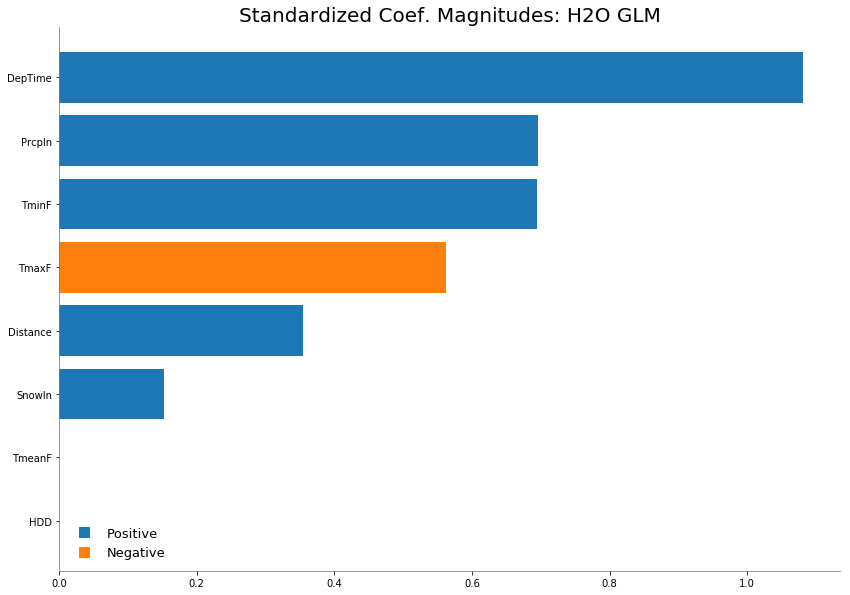

In [22]:
model.std_coef_plot()

# Regression

Having looked at classification, let's look at a regression problem: predicting the time delayed (given that a flight was delayed).

Here we should model our data with a GLM that is strictly positive. Indeed, if we choose Gaussian error with a log link we see a significant validation improvement over using an identity.

In [33]:
chicago_dep = chicago[chicago['Origin']=='ORD']
chicago_dep_delayed = chicago_dep[chicago_dep['DepDelay']>0]
x_cols = ['Month','DayOfWeek','DepTime','Distance','TmaxF','TminF','TmeanF','PrcpIn','SnowIn','CDD','HDD','GDD']
y_col = 'DepDelay'
model = H2OGeneralizedLinearEstimator(family='gaussian',link='log', response_column=y_col, nfolds=10)
model.train(x=x_cols, y=y_col, training_frame=chicago_dep_delayed)
model.show()

glm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1508442729868_50


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1882.91272125
RMSE: 43.3925422308
MAE: 29.6452625061
RMSLE: 1.21833976109
R^2: 0.319844753603
Mean Residual Deviance: 1882.91272125
Null degrees of freedom: 269
Residual degrees of freedom: 262
Null deviance: 747456.462963
Residual deviance: 508386.434738
AIC: 2820.18210563

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2104.06376017
RMSE: 45.8700747783
MAE: 30.9324999996
RMSLE: 1.24141028635
R^2: 0.239959457982
Mean Residual Deviance: 2104.06376017
Null degrees of freedom: 269
Residual degrees of freedom: 262
Null deviance: 753126.694874
Residual deviance: 568097.215246
AIC: 2850.1657949
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
mae,30.785872,3.3212814,37.089794,28.384007,26.732172,28.964516,39.375324,29.181059,22.607021,34.210114,30.236784,31.077932
mean_residual_deviance,2040.8085,485.76666,2903.4382,2350.6309,1090.1036,2865.1833,2275.9465,2611.0886,727.2097,1991.8848,1612.1559,1980.4438
mse,2040.8085,485.76666,2903.4382,2350.6309,1090.1036,2865.1833,2275.9465,2611.0886,727.2097,1991.8848,1612.1559,1980.4438
null_deviance,75312.67,22611.383,121951.66,78142.01,34029.184,95561.87,73519.664,85843.84,36429.156,59817.6,39679.207,128152.5
r2,0.1962596,0.0740456,0.1834826,0.1752109,0.241468,0.0402401,0.1766697,0.2084832,0.1639976,0.1238446,0.1781372,0.4710623
residual_deviance,56809.723,17533.51,95813.46,63467.03,25072.385,91685.87,54622.715,67888.305,18180.242,51789.004,32243.117,67335.09
rmse,44.39679,5.9048157,53.88356,48.483303,33.01672,53.52741,47.706882,51.098812,26.966825,44.630535,40.15166,44.50218
rmsle,1.2183752,0.1386143,1.2672775,1.2201701,1.0463051,1.3279744,1.0899316,0.9507572,1.4206163,1.6413794,1.0437952,1.1755449


Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2017-10-19 20:47:43,0.000 sec,0,373728.2314810,1384.1786351
,2017-10-19 20:47:43,0.002 sec,1,307106.4033470,1138.8303648
,2017-10-19 20:47:43,0.008 sec,2,258079.9474910,957.0072788
,2017-10-19 20:47:43,0.011 sec,3,255221.3692330,946.4770201
,2017-10-19 20:47:43,0.014 sec,4,254539.3421030,944.0076244
,2017-10-19 20:47:43,0.016 sec,5,254314.7479840,943.2076829
,2017-10-19 20:47:43,0.018 sec,6,254234.7630070,942.9312011
,2017-10-19 20:47:43,0.020 sec,7,254204.8895690,942.8324606
,2017-10-19 20:47:43,0.022 sec,8,254193.2173690,942.7965128
